The point of this notebook is to:

1. reproject the ASF radiometric and terrain corrected data into a single coordinate reference system.
2. crop the data to a smaller area
3. filter the time series according to month if relevant

In [1]:
import rasterio
from pathlib import Path
from rabasar import reproject_arr_to_match_profile, get_cropped_profile
from tqdm import tqdm
import lxml.etree as etree
import datetime
import numpy as np
import matplotlib.pyplot as plt
import json

# Read Config JSON

In [2]:
config_dict = json.load(open('config.json', 'r'))
config_dict

{'sensor': 'uavsar', 'site': 'waxlake', 'regularizer': 'tv'}

In [3]:
SENSOR = config_dict['sensor']
SITE = config_dict['site']
REGULARIZER = config_dict['regularizer']

# Data Paths

In [4]:
data_dir_path_name = f'{SENSOR}_{SITE}'
if REGULARIZER != 'tv':
    data_dir_path_name += '_tv'
DATA_DIR = Path(data_dir_path_name)
DATA_DIR.exists()

True

We name our data directories ready for reprojection in `f'{DATA_DIR}/data_original_tiff'`.

In [5]:
TIF_DIR = Path(f'{DATA_DIR}/data_original_tiff')
TIF_DIR.exists()

True

In [6]:
OUT_DIR = Path(f'{DATA_DIR}/data_reprojected')
OUT_DIR.mkdir(exist_ok=True, parents=True)

In [7]:
image_dirs = sorted(list(TIF_DIR.glob('./*/')))
image_dirs = list(filter(lambda x: x.is_dir(), image_dirs))
image_dirs

[PosixPath('uavsar_waxlake/data_original_tiff/190620'),
 PosixPath('uavsar_waxlake/data_original_tiff/190701'),
 PosixPath('uavsar_waxlake/data_original_tiff/190716'),
 PosixPath('uavsar_waxlake/data_original_tiff/190725'),
 PosixPath('uavsar_waxlake/data_original_tiff/190812'),
 PosixPath('uavsar_waxlake/data_original_tiff/190923'),
 PosixPath('uavsar_waxlake/data_original_tiff/190930')]

In [8]:
hh_paths = sorted(list(TIF_DIR.glob(f'./*/*HHHH*.tif')))
hv_paths = sorted(list(TIF_DIR.glob(f'./*/*HVHV*.tif')))
vv_paths = sorted(list(TIF_DIR.glob(f'./*/*VVVV*.tif')))

hv_paths

[PosixPath('uavsar_waxlake/data_original_tiff/190620/gulfco_27802_19038_011_190620_L090HVHV_CX_129A_03.tif'),
 PosixPath('uavsar_waxlake/data_original_tiff/190701/gulfco_27802_19043_030_190701_L090HVHV_CX_129A_02.tif'),
 PosixPath('uavsar_waxlake/data_original_tiff/190716/gulfco_27802_19048_007_190716_L090HVHV_CX_129A_03.tif'),
 PosixPath('uavsar_waxlake/data_original_tiff/190725/gulfco_27802_19051_008_190725_L090HVHV_CX_129A_03.tif'),
 PosixPath('uavsar_waxlake/data_original_tiff/190812/gulfco_27802_19053_019_190812_L090HVHV_CX_129A_03.tif'),
 PosixPath('uavsar_waxlake/data_original_tiff/190923/gulfco_27802_19069_008_190923_L090HVHV_CX_129A_02.tif'),
 PosixPath('uavsar_waxlake/data_original_tiff/190930/gulfco_27802_19070_010_190930_L090HVHV_CX_129A_02.tif')]

In [9]:
hv_paths[0].name[23:29]

'190620'

# Inspect Profiles

In [10]:
def get_profile(path):
    with rasterio.open(path) as ds:
        p = ds.profile
    return p
profiles = [get_profile(p) for p in hh_paths]
profiles

[{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 9745, 'height': 3332, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001, 0.0, -91.73885,
        0.0, -0.0001, 29.618250000000003), 'tiled': False, 'interleave': 'band'},
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 9733, 'height': 3335, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001, 0.0, -91.74125,
        0.0, -0.0001, 29.618750000000002), 'tiled': False, 'interleave': 'band'},
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 9697, 'height': 3331, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001, 0.0, -91.73885,
        0.0, -0.0001, 29.618550000000003), 'tiled': False, 'interleave': 'band'},
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 9745, 'height': 3335, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001, 0.0, -91.74005,
        0.0, -0.0001, 29.618550000000003), 'tiled': False, 'interleave

# Get Dates

In [11]:
def get_uavsar_date(image_path):
    element = image_path.name[23:29]
    date = datetime.date(int('20'+element[:2]), int(element[2:4]), int(element[4:6]))
    return date

def get_alos_date(image_path):
    raise NotImplementedError
    
def get_date(image_path):
    if SENSOR == 'uavsar':
        return get_uavsar_date(image_path)
    elif SENSOR == 'alos1':
        return get_alos_date(image_path)
    else:
        return ValueError('Check `config_dict[\'sensor\']`. Must be uavsar or alos1')

In [12]:
dates = list(map(get_date, hv_paths))
dates

[datetime.date(2019, 6, 20),
 datetime.date(2019, 7, 1),
 datetime.date(2019, 7, 16),
 datetime.date(2019, 7, 25),
 datetime.date(2019, 8, 12),
 datetime.date(2019, 9, 23),
 datetime.date(2019, 9, 30)]

# Filter by Date

In [13]:
MONTHS_TO_USE = list(range(1, 13))
MONTHS_TO_USE

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

We are removing first index because less coverage.

In [14]:
indices = [k for k, date in enumerate(dates) if date.month in MONTHS_TO_USE]
indices

[0, 1, 2, 3, 4, 5, 6]

In [15]:
hh_paths_filtered = [hh_paths[k] for k in indices]
hv_paths_filtered = [hv_paths[k] for k in indices]
vv_paths_filtered = [vv_paths[k] for k in indices]

hh_paths_filtered

[PosixPath('uavsar_waxlake/data_original_tiff/190620/gulfco_27802_19038_011_190620_L090HHHH_CX_129A_03.tif'),
 PosixPath('uavsar_waxlake/data_original_tiff/190701/gulfco_27802_19043_030_190701_L090HHHH_CX_129A_02.tif'),
 PosixPath('uavsar_waxlake/data_original_tiff/190716/gulfco_27802_19048_007_190716_L090HHHH_CX_129A_03.tif'),
 PosixPath('uavsar_waxlake/data_original_tiff/190725/gulfco_27802_19051_008_190725_L090HHHH_CX_129A_03.tif'),
 PosixPath('uavsar_waxlake/data_original_tiff/190812/gulfco_27802_19053_019_190812_L090HHHH_CX_129A_03.tif'),
 PosixPath('uavsar_waxlake/data_original_tiff/190923/gulfco_27802_19069_008_190923_L090HHHH_CX_129A_02.tif'),
 PosixPath('uavsar_waxlake/data_original_tiff/190930/gulfco_27802_19070_010_190930_L090HHHH_CX_129A_02.tif')]

In [16]:
profiles = [get_profile(p) for p in hh_paths_filtered]
profiles

[{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 9745, 'height': 3332, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001, 0.0, -91.73885,
        0.0, -0.0001, 29.618250000000003), 'tiled': False, 'interleave': 'band'},
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 9733, 'height': 3335, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001, 0.0, -91.74125,
        0.0, -0.0001, 29.618750000000002), 'tiled': False, 'interleave': 'band'},
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 9697, 'height': 3331, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001, 0.0, -91.73885,
        0.0, -0.0001, 29.618550000000003), 'tiled': False, 'interleave': 'band'},
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 9745, 'height': 3335, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001, 0.0, -91.74005,
        0.0, -0.0001, 29.618550000000003), 'tiled': False, 'interleave

In [17]:
REFERENCE_PROFILE = profiles[0].copy()
REFERENCE_PROFILE['driver'] = 'GTiff'
REFERENCE_PROFILE['nodata'] = np.nan

In [18]:
db_lower_bound = -40
db_upper_bound = 0
def clip_image(img):
    lb = np.power(10, db_lower_bound / 10.)
    ub = np.power(10, db_upper_bound / 10.)
    return np.clip(img, lb, ub)

In [19]:
REFERENCE_PROFILE

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 9745, 'height': 3332, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001, 0.0, -91.73885,
       0.0, -0.0001, 29.618250000000003), 'tiled': False, 'interleave': 'band'}

In [20]:
def read_one(image_path):
    with rasterio.open(image_path) as ds:
        img = ds.read(1)
        profile = ds.profile
        img = np.clip(img, 0, 1)
    return img, profile

def reproject_one(raster_path):
    img_src, profile_src = read_one(raster_path)
        
    img_r, profile_r = reproject_arr_to_match_profile(img_src, 
                                                      profile_src, 
                                                      REFERENCE_PROFILE, 
                                                      resampling='bilinear')
    img_r = clip_image(img_r)
    return img_r, profile_r

def write_reprojected(img_r, original_raster_path, pol):
    date = get_date(original_raster_path)

    dest_dir = Path(f'{OUT_DIR}/{pol}')
    dest_dir.mkdir(exist_ok=True, parents=True)
    dest_path = dest_dir/f'{SENSOR}_{SITE}_{pol}_RTC_{date.year}{date.month:02d}{date.day:02d}.tif'

    with rasterio.open(dest_path, 'w', **REFERENCE_PROFILE) as ds:
        ds.write(img_r)
    return dest_path

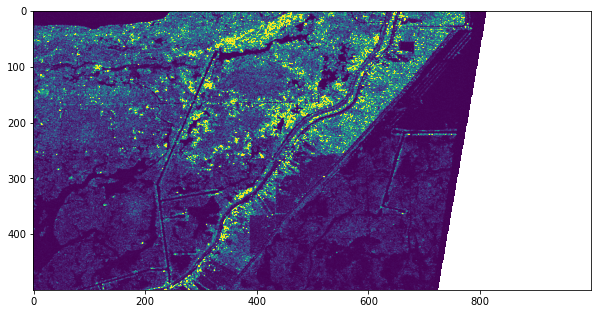

In [21]:
plt.figure(figsize=(10, 10))
arr, _ = read_one(hh_paths[1])
plt.imshow(arr[-1000:-500, -1000:], vmax=.5)

In [22]:
reprojected_data_hh = list(map(reproject_one, tqdm(hh_paths_filtered)))
reprojected_images_hh, _ = zip(*reprojected_data_hh)

100%|██████████| 7/7 [00:14<00:00,  2.13s/it]


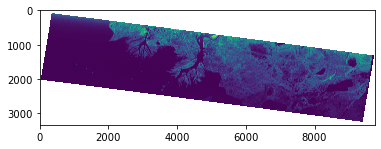

In [23]:
plt.imshow(reprojected_images_hh[0][0,...])

In [24]:
reprojected_data_hv = list(map(reproject_one, tqdm(hv_paths_filtered)))
reprojected_images_hv, _ = zip(*reprojected_data_hv)

100%|██████████| 7/7 [00:15<00:00,  2.15s/it]


In [25]:
reprojected_data_vv = list(map(reproject_one, tqdm(vv_paths_filtered)))
reprojected_images_vv, _ = zip(*reprojected_data_vv)

100%|██████████| 7/7 [00:15<00:00,  2.14s/it]


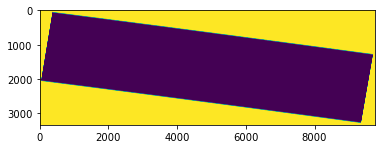

In [26]:
from functools import reduce

mask_ts = [np.isnan(img) for img in reprojected_images_hh]
ts_mask = list(reduce(np.logical_or, mask_ts))[0]

plt.imshow(ts_mask)

In [27]:
def apply_mask(img):
    img_ = img.copy()
    (img_[0,...])[ts_mask] = np.nan
    return img_

In [28]:
reprojected_images_hh = list(map(apply_mask, tqdm(reprojected_images_hh)))
reprojected_images_hv = list(map(apply_mask, tqdm(reprojected_images_hv)))
reprojected_images_vv = list(map(apply_mask, tqdm(reprojected_images_vv)))

100%|██████████| 7/7 [00:00<00:00, 12.26it/s]


In [29]:
from itertools import starmap

N = len(hh_paths_filtered)
list(starmap(write_reprojected, tqdm(zip(reprojected_images_hh, hh_paths_filtered, ['hh'] * N), total=N)))

100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


[PosixPath('uavsar_waxlake/data_reprojected/hh/uavsar_waxlake_hh_RTC_20190620.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hh/uavsar_waxlake_hh_RTC_20190701.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hh/uavsar_waxlake_hh_RTC_20190716.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hh/uavsar_waxlake_hh_RTC_20190725.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hh/uavsar_waxlake_hh_RTC_20190812.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hh/uavsar_waxlake_hh_RTC_20190923.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hh/uavsar_waxlake_hh_RTC_20190930.tif')]

In [30]:
list(starmap(write_reprojected, tqdm(zip(reprojected_images_hv, hv_paths_filtered, ['hv'] * N), total=N)))

100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


[PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190620.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190701.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190716.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190725.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190812.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190923.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190930.tif')]

In [31]:
list(starmap(write_reprojected, tqdm(zip(reprojected_images_vv, vv_paths_filtered, ['vv'] * N), total=N)))

100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


[PosixPath('uavsar_waxlake/data_reprojected/vv/uavsar_waxlake_vv_RTC_20190620.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/vv/uavsar_waxlake_vv_RTC_20190701.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/vv/uavsar_waxlake_vv_RTC_20190716.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/vv/uavsar_waxlake_vv_RTC_20190725.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/vv/uavsar_waxlake_vv_RTC_20190812.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/vv/uavsar_waxlake_vv_RTC_20190923.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/vv/uavsar_waxlake_vv_RTC_20190930.tif')]

# Copy DEM

In [35]:
dem_path = list(image_dirs[0].glob('*dem*.tif'))[0]
with rasterio.open(dem_path) as ds:
    dem = ds.read(1)
    dem_profile = ds.profile
dem[ts_mask] = np.nan

In [36]:
with rasterio.open(OUT_DIR/'dem.tif', 'w', **dem_profile) as ds:
    ds.write(dem, 1)